In [1]:
from collections import OrderedDict
from graph.workflow import order_from_tree
Ftree = OrderedDict([
        (1,1),
        (2,1),
        (3,2),
        (4,4),
        (5,4),
        (6,4),
        (7,3),
        (8,2)
    ])
Stree = {
    1: 2,
    3: 2,
    4: 3
}

In [6]:
order_from_tree(Ftree, Stree, {3: (True,)}, mergeendcomp=True)

[(SOLVER, 2, None),
 (SOLVER, 1, 2),
 (ENDCOMP, [1, 2], 1),
 (COMP, 3, 2),
 (SOLVER, 3, 2),
 (SOLVER, 4, 3),
 (ENDCOMP, [4, 5, 6], 4),
 (ENDCOMP, [7], 3),
 (ENDCOMP, [8], 2)]

In [9]:
test = [(1,2),3,([4,5,6],7),8]

In [9]:
def compute_order(seq_order, solve_order, parent=0, counter=0):
    counter+=1
    group = '{}.{}'.format(parent, counter)
    print(' '*len(group), 'create group: ', group)
    if solve_order:
        order = solve_order
        print(' '*len(group),'create system solver for ',group)
        if seq_order:
            compute_order(seq_order, (), group, counter)
    else:
        print(' '*len(group),'default sequential solver for ', group)
        order = seq_order
    for idx, eqnelt in enumerate(order):
        if isinstance(eqnelt, list):
            counter = compute_order(eqnelt, (), group, counter)
        elif isinstance(eqnelt, tuple):
            if isinstance(eqnelt[0], list):
                ordered = eqnelt[0]
                unordered = eqnelt[1:]
            else:
                ordered = []
                unordered = eqnelt
            counter = compute_order(ordered, unordered, group, counter)
        else:
            print(' '*(len(group)+2),'add to ', group, ' eq: ', eqnelt)
    return counter

In [11]:
compute_order([],test)

    create group:  0.1
    create system solver for  0.1
      create group:  0.1.2
      create system solver for  0.1.2
        add to  0.1.2  eq:  1
        add to  0.1.2  eq:  2
      add to  0.1  eq:  3
      create group:  0.1.3
      create system solver for  0.1.3
        create group:  0.1.3.4
        default sequential solver for  0.1.3.4
          add to  0.1.3.4  eq:  4
          add to  0.1.3.4  eq:  5
          add to  0.1.3.4  eq:  6
        add to  0.1.3  eq:  7
      add to  0.1  eq:  8


3

In [2]:
from compute import Evaluable, anp_math, evaluable_with_unit, Var, get_unit, ureg, coupled_run, buildidpvars, eqvar, unit_conversion_factors
from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, getdofs, idx_eqlist
from compute_utils import get_outputs, check_eqs
from representations import bipartite_repr, drawbipartite, digraph_repr
from utils import invmap
import sympy as sp
import openmdao.api as om
import numpy as np
import networkx as nx

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


In [54]:
from modeling.compute import Var
from modeling.execution import Component, edges_from_components
from graph.operators import invert_edges, sort_scc
from graph.graphutils import flat_graph_formulation
from graph.graphview import draw

In [47]:
a = Var('a')
b = Var('b')
c = Var('c', 10)
d = Var('d', 20)

In [48]:
eqlist = [(b, c+1), (a, b-2), (a, 2*d+3)]

In [49]:
edges = edges_from_components([Component.fromsympy(
    right, left, component=idx) for idx, (left, right) in enumerate(eqlist)])

In [50]:
invert_edges(edges[0], edges[1])

({0: ('c', 'b'), 1: ('b', 'a'), 2: ('d', 'a')},
 {0: (None,), 1: (None,), 2: (None,)},
 {})

In [51]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)

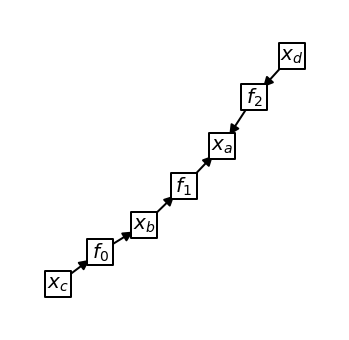

In [56]:
draw(G);

In [42]:
from trash.inputresolver import idx_eqlist, eqvars, default_out

In [40]:
eqs = idx_eqlist(eqlist)
eqv = eqvars(eqs)

In [43]:
dout = default_out(eqs)

In [195]:
ins = getdofs(eqs)
ins

{c, d}

In [196]:
B, edge = bipartite_repr(eqv)

In [197]:
M = nx.bipartite.maximum_matching(B)

In [204]:
order = mdf_order(eqv, M)

In [205]:
order

[1, 2, 0]

In [7]:
solve_order = ([0,1],2)

In [10]:
compute_order([],solve_order);

    create group:  0.1
    create system solver for  0.1
      create group:  0.1.2
      default sequential solver for  0.1.2
        add to  0.1.2  eq:  0
        add to  0.1.2  eq:  1
      add to  0.1  eq:  2


In [69]:
prob = om.Problem()
model = prob.model
counter = coupled_run(eqs, [], solve_order, model, model, 0)
buildidpvars(ins, model)
prob.setup()
prob.run_model()

RuntimeError: 'group1' <class Group>: Output name 'a' refers to multiple outputs: ['group1.eq2.a', 'group1.group2.eq1.a'].

In [112]:
(b-(c+1))

b - c - 1

In [114]:
ev = Evaluable.fromsympy(b-(c+1))

In [116]:
ev.evaldict({'b':1,'c':2})

-2

In [96]:
A = np.array([[0, 1, -1],[1, -1, 0],[1, 0, -2]])
B = np.array([1, -2, 3])
np.linalg.solve(A, B)

array([-5., -3., -4.])

In [160]:
residuals = [Evaluable.fromsympy(left-right) for key,(left,right) in eqs.items()]
vrs = [str(elt) for elt in set().union(*eqvars(eqs).values())]

In [ ]:
# create a group that only promotes the input/output variables and keep x hidden

In [164]:
class ImpWithInitial(om.ImplicitComponent):
    def initialize(self):
        self.options.declare('equations')
        self.options.declare('vrs')
        
    def setup(self):
        eqs = self.options["equations"]
        vrs = self.options["vrs"]
        self.add_output('x', val=0.1*np.ones(len(eqs)))
        self.declare_partials(of='*', wrt='*')

    def apply_nonlinear(self, inputs, outputs, residuals):
        eqs = self.options["equations"]
        vrs = self.options["vrs"]
        d = {elt: outputs['x'][idx] for idx,elt in enumerate(vrs)}
        residuals['x'] = np.array([eq.evaldict(d) for eq in eqs])
        
    def linearize(self, inputs, outputs, partials):
        eqs = self.options["equations"]
        vrs = self.options["vrs"]
        d = {elt: outputs['x'][idx] for idx,elt in enumerate(vrs)}
        n = len(vrs)
        p = np.zeros((n, n))
        for eqidx, eq in enumerate(eqs):
            J = eq.graddict(d)
            for i,var in enumerate(J):
                idx = vrs.index(eq.input_names[i])
                p[eqidx, idx] = var
        partials['x', 'x'] = p

        #self.inv_jac = 1.0 / (2 * a * x + b)
        
class Demux(om.ExplicitComponent):
    def setup(self):
        self.add_input('x', val=np.array([0.0,0.0,0.0]))
        self.add_output('a', val=0.0)
        self.add_output('b', val=0.0)
        self.add_output('c', val=0.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        outputs['a'],outputs['b'],outputs['c'] = inputs['x']

prob = om.Problem()
model = prob.model

model.add_subsystem('comp', ImpWithInitial(equations = residuals, vrs=vrs), promotes=['*'])
model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
model.linear_solver = om.ScipyKrylov()

prob.setup()
prob.run_model()

print(prob.get_val('comp.x'))

NL: Newton Converged in 1 iterations
[-4. -3. -5.]


In [1]:
model.list_outputs()

NameError: name 'model' is not defined